# Example for Feldman Cousins confidence interval construction

This requires that trials with different fluxes were run already. For this, see skripts `run_FC_trials.py` and `run_FC_trials_epeak.py`. Adjust file names as needed. I show first an example for the power-law spectrum and below an example for a customized spectrum.


In [1]:
import glob
import numpy as np

from icecube_flux import Source

import matplotlib.pyplot as plt

from matplotlib import image

plt.rc('text', usetex=True)

Load the source and the generated trial files.

## Example for power-law spectrum

In [2]:
my_source = Source(ra=77.35818516, dec=5.69314828, name="TXS 0506+056")
flux_norm, gamma = my_source.calculate_neutrino_flux(gamma_min=1, gamma_max=3.7)

name = "TXS0506+056"
plotting_path = "./"

# load your trials here, adjust filepath to lead to trials of your source. Here, TXS0506+056 had "index_8"
trial_files = glob.glob("../../neutrino_fluxes/neutrino_trials/FC_trials_minuit_index_8*_gamma_*.npy")
trials = np.load(trial_files[0])
if len(trial_files) > 1:
    for my_file in trial_files[1:]:
        trials = np.append(trials, np.load(my_file))

# this calculates the limits. Plots are made and saved so that we can evaluate if there is 
#sufficient sampling of the parameter space
limits = my_source.get_FC_uncertainties_per_gamma(trials, plot=True, path=plotting_path)

my_source.plot_FC_uncertainties(None, name, ns_limits=limits, 
                      path=plotting_path)

np.save("./" + name + "limits.npy", limits, allow_pickle=True)

flux_norm, flux_low, flux_high, energy_contour = my_source.get_flux_bowtie(limits, nevents=1e5, g_max=3.7)     
np.save("./flux_low_" + name + ".npy", flux_low)
np.save("./flux_high_" + name + ".npy", flux_high)
np.save("./energy_" + name + ".npy", energy_contour)

calculating best fit flux
creating analysis


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 4192.87it/s]


[10.  3.] -2.1487238911707767


[1.  1.3 1.6 1.9 2.2 2.5 2.8 3.1 3.4 3.4 3.7]
[1.0, 1.3, 1.6, 1.9000000000000001, 2.2, 2.5, 2.8000000000000003, 3.1000000000000005, 3.4, 3.4000000000000004, 3.7]


<Figure size 640x480 with 0 Axes>

Show an example of how limits are constructed. This is repeated for all simulated spectral indices. 


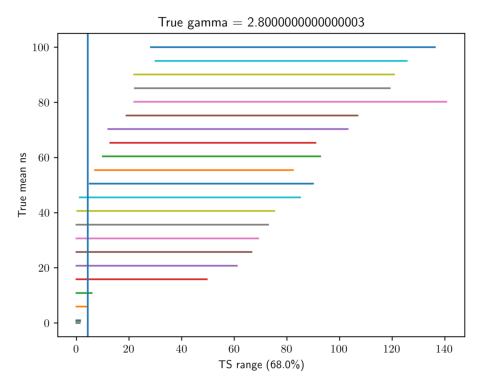

In [3]:
plot = image.imread("gamma2.8000000000000003.png")
plt.imshow(plot)
plt.axis('off')
plt.show()

The vertical line shows the data TS value. The horizontal lines show the central 68% quantiles of the TS distribution of as simulated flux with the respective gamma and the corresponding mean number of signal neutrinos. For example, the first broad red line from the bottom corresponds to a flux of on average 15 detected neutrinos with a spectrum of $E^{-2.8}$. 
The limit band for the respective spectral index (here 2.8) 
is the flux for the lowest and highest $n_S$ values crossing the horizontal lines. We evaluate these limits for all simulated spectral indices. 

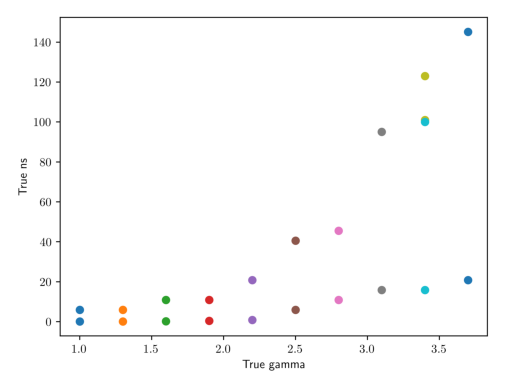

In [4]:
plot = image.imread("./FC_limits_TXS 0506+056.png")
plt.imshow(plot)
plt.axis('off')
plt.show()

This plot shows the upper and lower limit (in number of signal neutrinos $n_S$) for each simulated spectral index $E^{-\gamma}$. We can use this plot to make sure that the we have simulated higher fluxes than the highest upper limit. In the case of  $\gamma = 3.4$, we see several dots for the upper limit. This is because we have resimulated higher fluxes since we were hitting the upper simulated flux with our limits. For this example we have simulated $\approx 300$ flux realisations per parameter combination. Increasing this number (and having a smaller spacing between the parameters) will smoothen out the distribution. 

### Plot the "bowtie" or 68% uncertainty band

In [5]:
TeV_to_erg = 1.602
Hz_to_erg = 6.626e-27 
Hz_to_TeV = 4.136e-27


def plot_neutrino_bowtie(flux_low, flux_high, energy, ax=None):
    """ plots the uncertainty bands
    
    Parameters:
    -----------
    flux_low: lower flux limit in TeV
    flux_high: upper flux limit in TeV
    energy: energy in TeV
    
    Returns:
    --------
    figure ax
    line 2d part for legend plotting
    """
    if not ax:
        fig, ax = plt.subplots()

    high_mask = flux_high > 0
    low_mask = (flux_low < 1/1e3) & (flux_low > 0)
    plot_low_flux = []

    plot_low_flux = flux_low[low_mask]
    plot_high_flux = flux_high[high_mask]
        
    if len(plot_low_flux) > 0:
        
        ax.plot(energy[low_mask]/Hz_to_TeV, plot_low_flux*energy[low_mask]*energy[low_mask]*TeV_to_erg, 
                color="tab:green")
        
    icecube_ul, *args = ax.plot(energy[high_mask]/Hz_to_TeV, 
                                plot_high_flux*energy[high_mask]*energy[high_mask]*TeV_to_erg, 
                                color="tab:green", label=r"IceCube 68\% conf.")
    #  mask where both limits exist:
    mask = low_mask & high_mask
    
    lower_edge = flux_low[mask]
    
    ax.fill_between(energy[mask]/Hz_to_TeV, lower_edge*energy[mask]*energy[mask]*TeV_to_erg, 
                    flux_high[mask]*energy[mask]*energy[mask]*TeV_to_erg, 
                   alpha=0.5, color="tab:green")
    
    # plot upper limits where no lower flux limit available
    mask = (flux_low == 0) & (flux_low < 1/1e3) & high_mask
    
    n_arrows = 70
    ax.errorbar(energy[mask][::n_arrows]/Hz_to_TeV, 
                flux_high[mask][::n_arrows]*energy[mask][::n_arrows]*energy[mask][::n_arrows]*TeV_to_erg,
            yerr=flux_high[mask][::n_arrows]*energy[mask][::n_arrows]*energy[mask][::n_arrows]*TeV_to_erg * 0.8, 
            uplims=[True] * len(flux_high[mask][::n_arrows]), 
            fmt=".", color="tab:green", 
            alpha=1, markersize=1, capsize=0)
    
    return ax, icecube_ul


Text(0.5, 0, '$\\nu$~[Hz]')

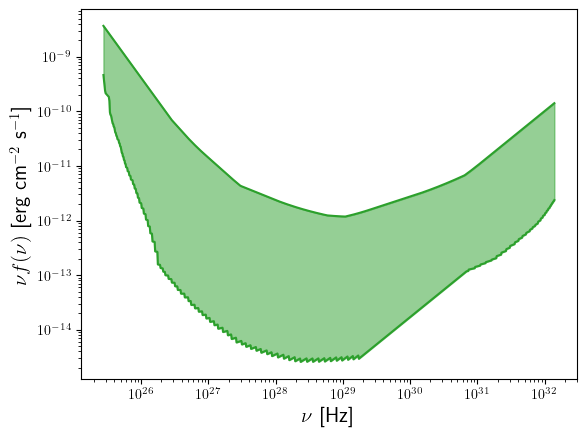

In [10]:
fontsize=15
plot_neutrino_bowtie(flux_low * 1e3, flux_high * 1e3, energy_contour)
plt.loglog()
plt.ylabel(r"$\nu f(\nu)$~[erg cm$^{-2}$ s$^{-1}$]", fontsize=fontsize)

plt.xlabel(r"$\nu$~[Hz]", fontsize=fontsize, labelpad=4)


The 68% confidence band of the power-law neutrino flux at the position of TXS 0506+056. The shaded region is constructed by the overlapping possible power-law spectra. This quantity has no bias. The curve will be smoother with a better sampling of the parameter space. 

## Example for a customized spectrum (here for a peaked spectrum based on p$\gamma$ interaction)

In [7]:
# load here your customized neutrino flux templates. 
#For a peaked spectrum, load the flux and energy as seperate arrays. 
example_energies = np.load("../../neutrino_fluxes/nu_template_energy_gev.npy")
example_flux = np.load("../../neutrino_fluxes/nu_template_nufnu_gev_percmsq_persecond.npy")

In [8]:
my_source_epeak = Source(ra=77.35818516, dec=5.69314828, name="TXS 0506+056")
flux_norm, epeak = my_source_epeak.calculate_epeak_neutrino_flux(
    source_energy_spectrum=example_flux, 
    source_energies=example_energies, 
    epeak_min=3, epeak_max=9.6)

name = "TXS0506+056"
plotting_path = "./"

# load your trials here, adjust filepath to lead to trials of your source. Here, TXS0506+056 had "index_8"
trial_files = glob.glob("../../neutrino_fluxes/neutrino_trials/FC_trials_index_8*_epeak_*.npy")
trials = np.load(trial_files[0])
if len(trial_files) > 1:
    for my_file in trial_files[1:]:
        trials = np.append(trials, np.load(my_file))

# this calculates the limits. Plots are made and saved so that we can evaluate if there is 
#sufficient sampling of the parameter space
epeak_limits = my_source_epeak.get_FC_uncertainties_per_epeak(trials, plot=True, path=plotting_path)

my_source_epeak.plot_FC_uncertainties(None, name, ns_limits=epeak_limits, 
                      path=plotting_path)

np.save("./" + name + "_epeak_limits.npy", epeak_limits, allow_pickle=True)

epeak_bins = np.arange(4, 9.6, 0.71)

epeak_flux_norm, epeak_flux_low, epeak_flux_high, epeak_energy_contour = my_source_epeak.get_flux_bowtie(
    epeak_limits, nevents=1e5, g_min=4, g_max=9., epeak_model=True, bins=epeak_bins)   

np.save("./epeak_flux_low_" + name + ".npy", epeak_flux_low)
np.save("./epeak_flux_high_" + name + ".npy", epeak_flux_high)
np.save("./epeak_energy_" + name + ".npy", epeak_energy_contour)

calculating best fit flux
creating epeak analysis


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 845/845 [00:03<00:00, 265.77it/s]


[4.  4.4 4.8 5.2 5.6 6.  6.4 6.8 7.2 7.6 8.  8.4 8.8 9.2]
[4.0, 4.4, 4.800000000000001, 5.200000000000001, 5.600000000000001, 6.000000000000002, 6.400000000000002, 6.8000000000000025, 7.200000000000003, 7.600000000000003, 8.000000000000004, 8.400000000000004, 8.800000000000004]


<Figure size 640x480 with 0 Axes>

Text(0.5, 0, '$\\nu$~[Hz]')

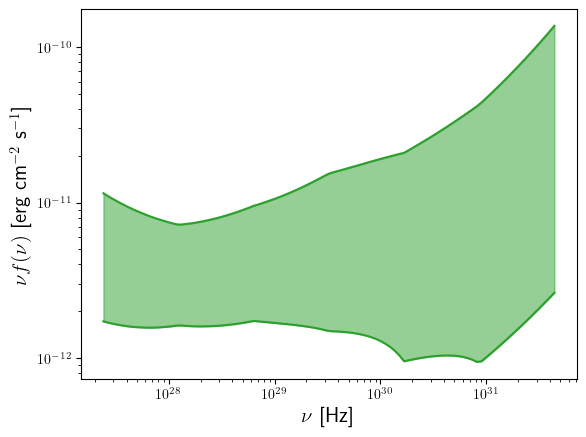

In [27]:
fontsize=15
# Note the different energy units here (GeV). This depends on the analysis instance in SkyLLH. 
plot_neutrino_bowtie(epeak_flux_low * 1e3, epeak_flux_high * 1e3, epeak_energy_contour / 1e3)
plt.loglog()
plt.ylabel(r"$\nu f(\nu)$~[erg cm$^{-2}$ s$^{-1}$]", fontsize=fontsize)

plt.xlabel(r"$\nu$~[Hz]", fontsize=fontsize, labelpad=4)

The 68% confidence band of the epeak neutrino flux at the position of TXS 0506+056. The shaded region is constructed by the overlapping possible peak values. This quantity has no bias. The curve will be smoother with a better sampling of the parameter space. 